In [19]:
import numpy as np
import jax

from jax import random
from jax import device_put
from jax import jit
from jax import numpy as jnp
from matplotlib import pyplot as plt

In [5]:
jax.default_backend()

'cpu'

## NumPy-like JAX

In [6]:
t = jnp.linspace(0,1,100)
f = jnp.sin(20 * t)

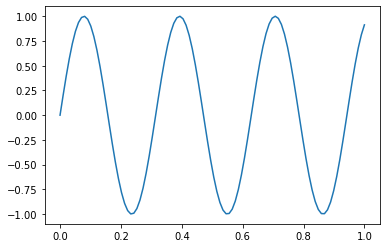

In [7]:
plt.plot(t,f)

## Immutable Arrays

In [8]:
x = jnp.arange(10)
print(x)
x[0] = 10

[0 1 2 3 4 5 6 7 8 9]


TypeError: '<class 'jaxlib.xla_extension.DeviceArray'>' object does not support item assignment. JAX arrays are immutable. Instead of ``x[idx] = y``, use ``x = x.at[idx].set(y)`` or another .at[] method: https://jax.readthedocs.io/en/latest/_autosummary/jax.numpy.ndarray.at.html

In [9]:
x = x.at[0].set(10)
print(x)

[10  1  2  3  4  5  6  7  8  9]


In [10]:
key = random.PRNGKey(0)
x = random.normal(key, (2,5))
print(x)

[[-0.3721109   0.26423115 -0.18252768 -0.7368197  -0.44030377]
 [-0.1521442  -0.67135346 -0.5908641   0.73168886  0.5673026 ]]


In [11]:
x = x.at[0].set(jnp.arange(5))
print(x)

[[ 0.          1.          2.          3.          4.        ]
 [-0.1521442  -0.67135346 -0.5908641   0.73168886  0.5673026 ]]


In [12]:
x = x.at[:,0].set(jnp.arange(2))
print(x)

[[ 0.          1.          2.          3.          4.        ]
 [ 1.         -0.67135346 -0.5908641   0.73168886  0.5673026 ]]


In [13]:
print(type(x))

<class 'jaxlib.xla_extension.DeviceArray'>


## JAX Compute = Speed

In [14]:
x_np = np.random.randn(10000)
x_jnp = random.normal(key, (10000,))

In [15]:
%timeit jnp.dot(x_jnp, x_jnp.T)
%timeit jnp.dot(x_jnp, x_jnp.T).block_until_ready()
%timeit x_jnp @ x_jnp.T

21.9 µs ± 62.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
23.1 µs ± 101 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
22.8 µs ± 48.8 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
%timeit np.dot(x_np, x_np.T)
%timeit x_np @ x_np.T

3.66 µs ± 721 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
3.14 µs ± 717 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [18]:
x_np_device = device_put(x_np)
%timeit jnp.dot(x_np_device, x_np_device.T).block_until_ready()
%timeit x_np_device @ x_np_device.T

23 µs ± 47.2 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
22.9 µs ± 135 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## JAX Transformation Functions

#### Using ```jit()```

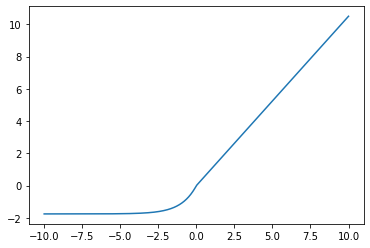

In [21]:
def selu(x, alpha=1.67, lmbda=1.05):
    return lmbda * jnp.where(x > 0, x, alpha * jnp.exp(x) - alpha)

x = jnp.linspace(-10,10,1000)
plt.plot(x, selu(x))

In [24]:
selu_jit = jit(selu)

In [23]:
data = random.normal(key, (1000000,))
%timeit selu(data).block_until_ready()
%timeit selu_jit(data).block_until_ready()

1.25 ms ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
319 µs ± 641 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)


#### Using ```grad()```

#### Using ```vmap()```